# Big project

## Submission

Submit solutions to https://forms.office.com/e/WexY7YraJb.

1.   Upload code in .ipynb file
2.   Upload a csv containing three columns: 
*    "ID": the ID of the instance (1, 2, 3, ...)
*    "OBJ": the objective function value obtained
*    "TIME": the execution time in seconds.

## Evaluation

1.   Gap w.r.t. optimal solutions
2.   Runtimes. Must be under 10 minutes for every instance[" Execution times will be re-examined on a random basis.

## Deadline

12/01/2022 23:59 CET

## Other

*   4 lab points just if you deliver something that works
*   10 points based on the quality of method
*   NO pre-coded libraries, 
*   NO genetic algorithms 
*   NO neural networks
*   groups of max 3 students




## Biogas plants location

An association of $n$ farmers wants to open $p$ plants to produce energy from biogas. 
Each plant will be opened at a farm of a member of the association and will be powered with corn chopping purchased from the farm itself or from other neighboring farms.

Each farm $i$ can provide at most $c_i$ tons of corn chopping, with a percentage of dry matter $a_i$. As you may know, dry matter is the key component of corn chopping used for biogas production. In order to maintain the quality of produced energy, each plant must burn a mixture of corn chopping with a percentage of dry matter between $k_{min}$ and $k_{max}$. 

At most one plant can be located in each farm, and every farm can sell its corn chopping to one and only one plant.

Each farm $i$ is located at coordinates $x_i$ and $y_i$, representing respectively its latitude and longitude, and the cost of moving corn chopping from a farm $i$ to a farm $j$ is proportional to the euclidean distance between the two farms (it does not depend on the actual quantity moved, since the trucks used for this transportations are sufficiently big). 

Under such conditions, every plant produces $Q$ kWh of energy per ton of corn chopping burned. The energy produced by each plant will be fed into the national electricity system, at a unitary price of $b$ (€/kWh). Moreover, due to state regulations, each plant must not produce more than $M$ kWh of energy.

You must locate $p$ plants among the available farms and assign the farms that will supply each plant, with the goal of maximizing the total revenues of the association.

### Sets
*   $I$ = set of farms

### Parameters
*   $n$ = number of farms   
*   $p$ = number of plants to locate
*   $b$ = revenue per unit of energy (€/kWh)
*   $M$ = max energy production (kWh)
*   $Q$ = energy produced by a ton of corn chopping (kWh/t)
*   $k_{min} (k_{max})$ = min (max) percentage of dry matter for fermentation
*   $a_i$ = percentage of dry matter in chopping from farm $i \in I$
*   $c_i$ = tons of corn chopping available for each $i \in I$ (t)
*   $x_i, y_i$ = coordinates of farm $i \in I$

In [1]:
import json

# Reads a .json instance and returns it in a dictionary
def load_instance(filename):
  with open(filename, 'r') as f:
    data = json.load(f)
  return data

# Reads a .txt result and returns it
def load_result(filename):
  with open(filename, 'r') as f:
      result = f.read()
  return float(result)

In [2]:
import mip
import numpy as np

def fast_distance_matrix(x):
    x = np.array(x)
    #
    # Inspired by: 
    # https://github.com/eth-cscs/PythonHPC/blob/master/numpy/03-euclidean-distance-matrix-numpy.ipynb
    #
    # The "Euclidean Trick" math: 
    # https://www.robots.ox.ac.uk/~albanie/notes/Euclidean_distance_trick.pdf
    #
    xy = x @ x.T
    x2 = xy.diagonal()[:,np.newaxis]
    return np.abs(x2 + x2.T - 2. * xy)**0.5

def solve_but_you_are_lorenzo_benzoni(instance):
    farms = range(instance["n"])        # number of farms
    plants = range(instance["p"])       # number of plants
    corn_chopping = instance["c"]       # vector of corn chopping production for each farm
    dry_matter = instance["a"]          # vector dry matter percentage per each farm
    farm_location = instance["points"]  # vector of farm locations (x,y)
    plant_efficency = instance["Q"]     # quantity of biogas produced per each plant per each ton of corn chopped
    energy_value = instance["b"]        # energy value of biogas (€/kWh)
    max_energy = instance["M"]          # energy limit for the whole system (kWh)
    min_dry_matter = instance["kmin"]
    max_dry_matter = instance["kmax"]

    m = mip.Model(name="biogas-plant-location", sense=mip.MAXIMIZE)
    
    ## Variables ##
    # x[i][j] = 1 if plant j is located at farm i
    x = [[m.add_var(var_type=mip.BINARY) for j in farms] for i in plants]

    # y[i][j] = 1 if farm i is connected to farm j
    y = [[m.add_var(var_type=mip.BINARY) for j in farms] for i in farms]

    # sold fuel from farm i
    sold_fuel = [[m.add_var() for i in farms] for j in farms]


    ## Constraints ##
    
    '''
    @vector of size p
    1 if plant i is built in any location
    0 otherwise
    '''
    is_plant_build = [mip.xsum(x[i][j] for j in farms) for i in plants]

    # each plant is connected to exactly one farm
    for i in plants:
        m += is_plant_build[i] == 1

    '''
    @vector
    listing the number of plants build in each farm
    '''
    plants_in_farm = [mip.xsum(x[i][j] for i in plants) for j in farms]

    # each farm has at most one plant
    for i in farms:
        m += plants_in_farm[i] <= 1


    '''
    @vector
    1 if farm i is connected to any other farm,
        the other farm must include a plant!
    0 otherwise
    '''
    farm_farm_connections = [mip.xsum(y[i][j] for j in farms) for i in farms]
    
    # each farm sell to at most one plant
    for i in farms:
        m += farm_farm_connections[i] <= 1

    # if y_ij = 1 then x_kj = 1 for any k in plants
    for i in farms:
        for j in farms:
            m += y[i][j] <= mip.xsum(x[k][j] for k in plants)
    
    '''
    not necessary => https://webeep.polimi.it/mod/forum/discuss.php?d=57341
    # farm i sell to a plant j
    for i in farms:
        m += mip.xsum(y[i][j] for j in plants) == 1
    '''

    # fuel can be sold only from connected farms
    for i in farms:
        for j in farms:
            m += sold_fuel[i][j] <= y[i][j] * corn_chopping[i]

    # fuel constraints
    bought_fuel = [mip.xsum(sold_fuel[i][j] for i in farms) for j in farms] 
    dry_matter_in_bought_fuel = [mip.xsum(sold_fuel[i][j] * dry_matter[i] for i in farms) for j in farms]
    for i in farms:
        m += dry_matter_in_bought_fuel[i] >= min_dry_matter * bought_fuel[i]
        m += dry_matter_in_bought_fuel[i] <= max_dry_matter * bought_fuel[i]

    # energy production cannot exceed limit
    for i in farms:
        m += bought_fuel[i] * plant_efficency <= max_energy
        

    ## Objective function ##

    # sold energy!
    earnings = mip.xsum(bought_fuel[i] * plant_efficency * energy_value for i in farms)

    # cost of transportation from farm i to plant j
    distance = fast_distance_matrix(farm_location)
    
    #transp_cost = mip.xsum( distance[i][j] * y[i][j] # need to divide the distance because is counted twice
    #                       for i in range(j, len(farms)) for j in farms)

    m.objective = mip.maximize(earnings) #- transp_cost)

    ## Optimization ##

    m.verbose = 0
    m.emphasis = 1 # FEASIBLE
    m.optimize(max_seconds=600)

    ## Output ##

    print("\nOptimization status: {}".format(m.status))
    print("Optimal solution, without transportation cost: {}".format(m.objective_value))
    transp_cost = sum([distance[i][j]*y[i][j].x for i in range(j, len(farms)) for j in farms])

    print("Optimal soluzion, accounting for the transportation cost: {}".format(m.objective_value - transp_cost))
    print("Difference: " + str(abs(100-(m.objective_value - transp_cost)/m.objective_value*100)) + " %")

    #plot the plants & farms
    plant_location = []
    for i in plants:
        for j in farms:
            if x[i][j].x == 1:
                plant_location.append(farm_location[j])
                break
    
    import matplotlib.pyplot as plt
    plt.scatter([x[0] for x in farm_location], [x[1] for x in farm_location], color='blue')
    plt.scatter([x[0] for x in plant_location], [x[1] for x in plant_location], color='red')
    
    plt.xlim(0, 100)
    plt.show()

    return m.objective_value


In [3]:
def test(n):
    inst = load_instance('instances/instance_'+str(n)+'.json')
    res = load_result("results/instance_"+str(n)+".txt")
    obj = solve_but_you_are_lorenzo_benzoni(inst)
    print(res)
    print("Goodness: " + str((obj - res) / res))


Optimization status: OptimizationStatus.OPTIMAL
Optimal solution, without transportation cost: 1324617.2915704667
Optimal soluzion, accounting for the transportation cost: 1324617.2915704667
Difference: 0.0 %


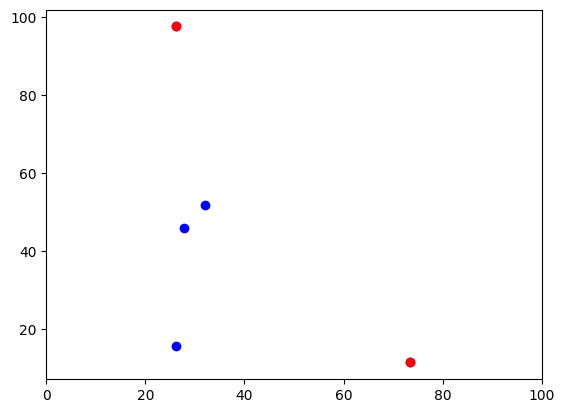

1324477.6736137536
Goodness: 0.00010541359774841357

Optimization status: OptimizationStatus.OPTIMAL
Optimal solution, without transportation cost: 385739.65561196243
Optimal soluzion, accounting for the transportation cost: 385674.1968948352
Difference: 0.016969662355137416 %


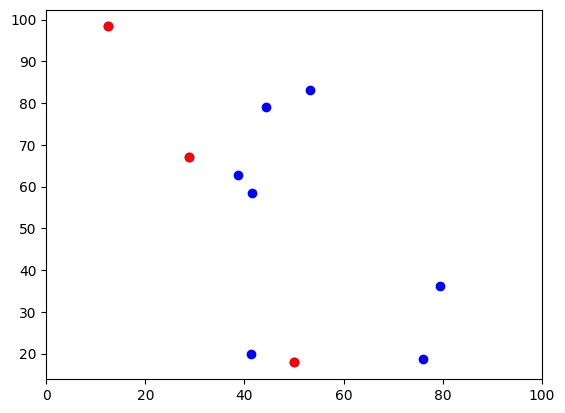

385611.91779212654
Goodness: 0.00033126004135783236
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.285975
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.28395e+06 iterations 12
Cbc0038I Solution found of 1.28395e+06
Cbc0038I Relaxing continuous gives 1.28395e+06
Cbc0038I Before mini branch and bound, 34 integers at bound fixed and 27 continuous
Cbc0038I Full problem 72 rows 65 columns, reduced to 1 rows 2 columns
Cbc0038I Mini branch and bound did not improve solution (0.01 seconds)
Cbc0038I Round again with cutoff of 1.28964e+06
Cbc0038I Reduced cost fixing fixed 1 variables on major pass 2
Cbc0038I Pass   2: suminf.    0.02860 (2) obj. 1.28964e+06 iterations 17
Cbc0038I Pass   3: suminf.    0.84482 (2) obj. 1.28964e+06 iterations 36
Cbc0038I Pass   4: suminf.    0.50326 (3) obj. 1.28964e+06 iterations 10
Cbc0038I Pass   5: suminf.    0.00000 (0) obj. 1.28964e+06 iterations 14
Cbc0038I Solution found of 1.28964e+06
Cbc0038I Relaxing continuous gives 1.30391e+06
Cbc0038I Bef

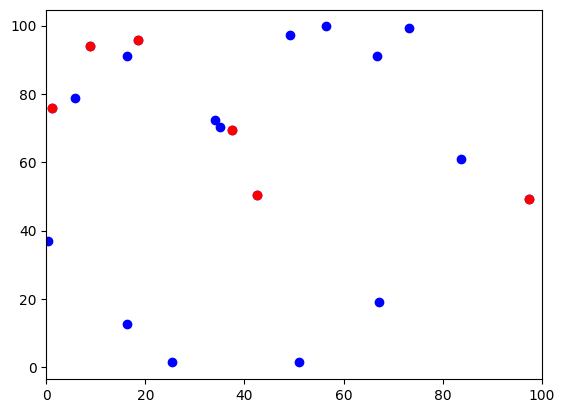

2357066.9429236925
Goodness: 0.00026513849848187817
92 on tree, 2357691.9 best solution, best possible 2358337.5 (513.01 seconds)
Cbc0010I After 140309 nodes, 5222 on tree, 2357691.9 best solution, best possible 2358337.5 (513.72 seconds)
Cbc0010I After 140636 nodes, 5258 on tree, 2357691.9 best solution, best possible 2358337.5 (514.42 seconds)
Cbc0010I After 140786 nodes, 5276 on tree, 2357691.9 best solution, best possible 2358337.5 (515.13 seconds)
Cbc0010I After 140985 nodes, 5285 on tree, 2357691.9 best solution, best possible 2358337.5 (515.83 seconds)
Cbc0010I After 141193 nodes, 5274 on tree, 2357691.9 best solution, best possible 2358337.5 (516.53 seconds)
Cbc0010I After 141388 nodes, 5266 on tree, 2357691.9 best solution, best possible 2358337.5 (517.23 seconds)
Cbc0010I After 141600 nodes, 5272 on tree, 2357691.9 best solution, best possible 2358337.5 (517.93 seconds)
Cbc0010I After 141800 nodes, 5235 on tree, 2357691.9 best solution, best possible 2358337.5 (518.64 seconds

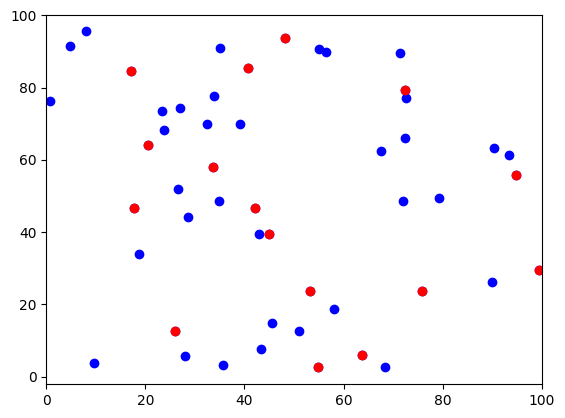

9414476.549923249
Goodness: 6.525880063073997e-05


In [4]:
test(1)
test(2)
test(3)
test(4)


Optimization status: OptimizationStatus.OPTIMAL
Optimal solution, without transportation cost: 5803579.616998415
Optimal soluzion, accounting for the transportation cost: 5803542.3139224155
Difference: 0.0006427597872686874 %


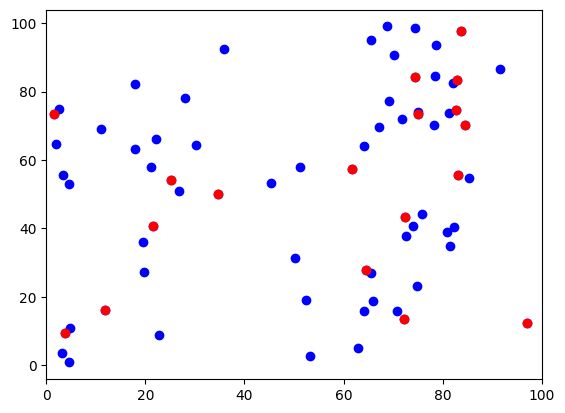

5803579.616998415

In [5]:
n = 5
inst = load_instance('instances/instance_'+str(n)+'.json')
solve_but_you_are_lorenzo_benzoni(inst)

6e+06 iterations 888
Cbc0038I Pass  25: (1.47 seconds) suminf.    3.64615 (18) obj. 9.1946e+06 iterations 979
Cbc0038I Pass  26: (1.49 seconds) suminf.    1.55173 (13) obj. 9.1946e+06 iterations 206
Cbc0038I Pass  27: (1.52 seconds) suminf.    2.37085 (10) obj. 9.1946e+06 iterations 273
Cbc0038I Pass  28: (1.55 seconds) suminf.    1.30521 (11) obj. 9.1946e+06 iterations 237
Cbc0038I Pass  29: (1.57 seconds) suminf.    2.35543 (11) obj. 9.1946e+06 iterations 224
Cbc0038I Pass  30: (1.59 seconds) suminf.    1.40132 (9) obj. 9.1946e+06 iterations 165
Cbc0038I Pass  31: (1.61 seconds) suminf.    1.50038 (7) obj. 9.1946e+06 iterations 172
Cbc0038I No solution found this major pass
Cbc0038I Before mini branch and bound, 2887 integers at bound fixed and 2178 continuous
Cbc0038I Full problem 5266 rows 5800 columns, reduced to 840 rows 725 columns
Cbc0038I Mini branch and bound improved solution from 9.1701e+06 to 9.18319e+06 (2.26 seconds)
Cbc0038I Round again with cutoff of 9.2387e+06
Cbc0038

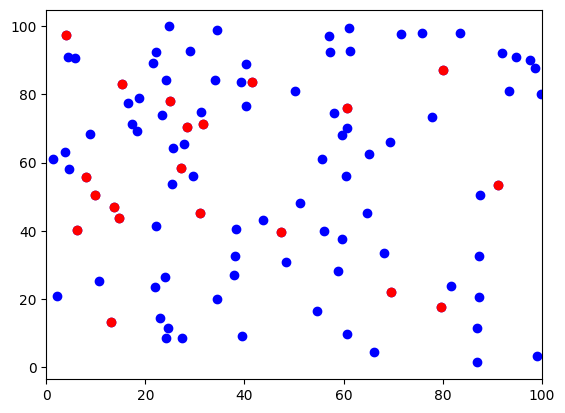

8032565.823166459

In [6]:
n = 6
inst = load_instance('instances/instance_'+str(n)+'.json')
solve_but_you_are_lorenzo_benzoni(inst)

51.71 seconds)
Cbc0010I After 4688 nodes, 4088 on tree, 8032565.8 best solution, best possible 12118923 (552.48 seconds)
Cbc0010I After 4689 nodes, 4088 on tree, 8032565.8 best solution, best possible 12118923 (554.40 seconds)
Cbc0010I After 4691 nodes, 4088 on tree, 8032565.8 best solution, best possible 12118923 (555.40 seconds)
Cbc0010I After 4693 nodes, 4089 on tree, 8032565.8 best solution, best possible 12118923 (556.91 seconds)
Cbc0010I After 4696 nodes, 4091 on tree, 8032565.8 best solution, best possible 12118923 (557.75 seconds)
Cbc0010I After 4697 nodes, 4091 on tree, 8032565.8 best solution, best possible 12118923 (559.37 seconds)
Cbc0010I After 4700 nodes, 4093 on tree, 8032565.8 best solution, best possible 12118923 (560.07 seconds)
Cbc0010I After 4701 nodes, 4093 on tree, 8032565.8 best solution, best possible 12118923 (561.54 seconds)
Cbc0010I After 4702 nodes, 4093 on tree, 8032565.8 best solution, best possible 12118923 (563.56 seconds)
Cbc0010I After 4705 nodes, 4095

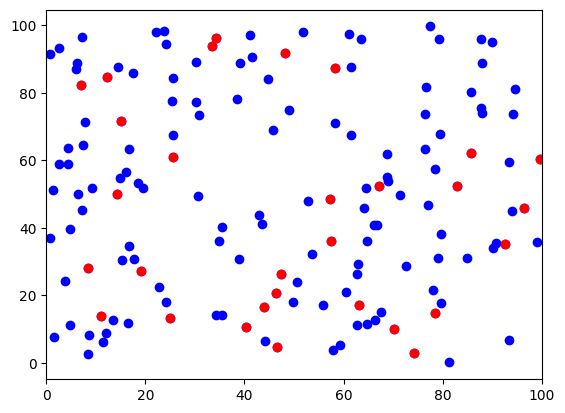

17792278.840964958

In [7]:
n = 7
inst = load_instance('instances/instance_'+str(n)+'.json')
solve_but_you_are_lorenzo_benzoni(inst)


Optimization status: OptimizationStatus.FEASIBLE
Optimal solution, without transportation cost: 24880011.360727366
Optimal soluzion, accounting for the transportation cost: 24879963.385504566
Difference: 0.00019282637015294313 %


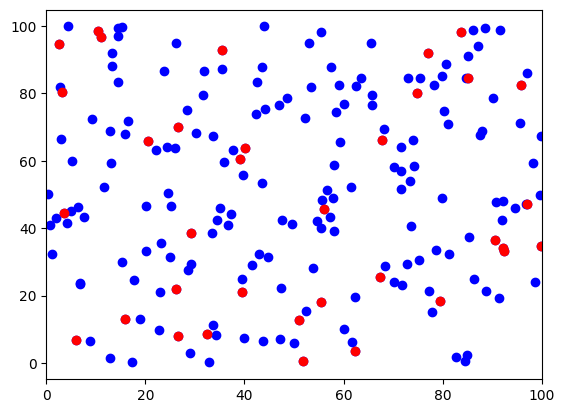

24880011.360727366

In [8]:
n = 8
inst = load_instance('instances/instance_'+str(n)+'.json')
solve_but_you_are_lorenzo_benzoni(inst)


Optimization status: OptimizationStatus.FEASIBLE
Optimal solution, without transportation cost: 9232845.469548771
Optimal soluzion, accounting for the transportation cost: 9232806.409257598
Difference: 0.0004230579976933768 %


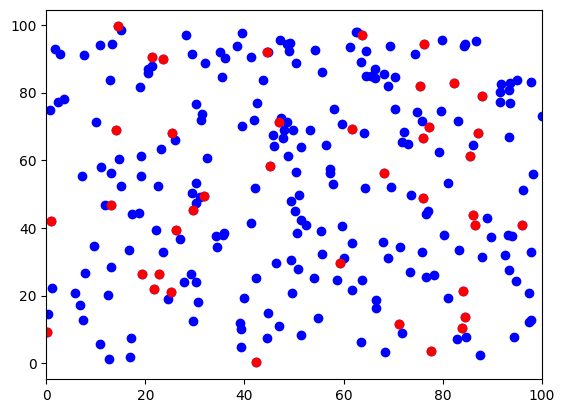

9232845.469548771

In [10]:
n = 9
inst = load_instance('instances/instance_'+str(n)+'.json')
solve_but_you_are_lorenzo_benzoni(inst)

In [11]:
n = 10
inst = load_instance('instances/instance_'+str(n)+'.json')
solve_but_you_are_lorenzo_benzoni(inst)